In [1]:
%%capture state
from __future__ import division
from __future__ import print_function

import sys, os
sys.path.append('./src/')

import tensorflow as tf
import numpy as np

from influence.neural_network import NeuralNetwork
from influence.cnn import CNN
import influence.util as util

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#Seed used for all calculations of training and test point indices 
SEED = 14

In [2]:
## Visualization of samples
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(image):
    plt.figure(figsize=(1, 1))
    if image.shape[-1] == 1:
        # image is in black and white
        image = image[:, :, 0]
        plt.imshow(image, cmap='Greys')
    else:
        # image is in color
        plt.imshow(image)
    plt.axis('off')
    plt.show()

#Normalize rows of a given matrix
def normalize(matrix):
    matrix_nm = np.zeros_like(matrix)
    for i in range(matrix.shape[0]):
        matrix_nm[i] = matrix[i]/np.linalg.norm(matrix[i]) 
    return matrix_nm

In [3]:
#Load model from disk
model_name = 'SVHN-Pool'
model_save_path = './trained_models/' + model_name + '-model.json'
weights_save_path = './trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='svhn_pool')
epochs = 50
model.train(epochs=epochs)
model.save_model(model_save_path, weights_save_path)    

Train on 73257 samples, validate on 13016 samples
Epoch 1/50
73257/73257 [==============================] - 12s 163us/step - loss: 3.8482 - acc: 0.2446 - val_loss: 1.6606 - val_acc: 0.5133
Epoch 2/50
73257/73257 [==============================] - 10s 135us/step - loss: 1.0082 - acc: 0.7497 - val_loss: 0.7012 - val_acc: 0.8464
Epoch 3/50
73257/73257 [==============================] - 10s 135us/step - loss: 0.6395 - acc: 0.8571 - val_loss: 0.5753 - val_acc: 0.8943
Epoch 4/50
73257/73257 [==============================] - 10s 137us/step - loss: 0.5340 - acc: 0.8830 - val_loss: 0.5118 - val_acc: 0.8911
Epoch 5/50
73257/73257 [==============================] - 10s 137us/step - loss: 0.4789 - acc: 0.8972 - val_loss: 0.4288 - val_acc: 0.9165
Epoch 6/50
73257/73257 [==============================] - 10s 134us/step - loss: 0.4397 - acc: 0.9058 - val_loss: 0.3725 - val_acc: 0.9272
Epoch 7/50
73257/73257 [==============================] - 10s 135us/step - loss: 0.4091 - acc: 0.9133 - val_loss: 0.

In [4]:
#Get training samples
num_train_samples = 10000
data_indices = model.gen_rand_indices(low=0, high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

In [5]:
num_test_samples_per_class = 100
num_test_samples = 10*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

#Get Regular, Noisy, FGSM, BIM, and CW test points
reg_data = model.test_data[test_indices]
noisy_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='Noisy')
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='FGSM')
bim_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices], seed=SEED, perturbation='BIM', iterations=10)
cw_data = model.generate_perturbed_data(model.test_data[test_indices], model.test_labels[test_indices],seed=SEED, perturbation='CW', targeted=False)

/root/notebook/cleverhans/cleverhans/src/cleverhans/cleverhans/utils_keras.py:144: UserWarning: Please update your version to keras >= 2.1.3; support for earlier keras versions will be dropped on 2018-07-22
  "Please update your version to keras >= 2.1.3; "


In [10]:
#Reset tf.graph() as Cleverhans modifies the graph
tf.reset_default_graph()

#Reload the model and weights
model = CNN(model_name=model_name, dataset='svhn_pool')
model.load_model(model_save_path, weights_save_path)    

Loaded model from disk


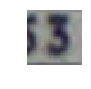

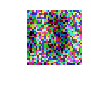

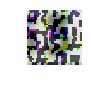

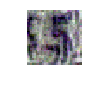

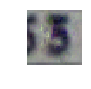

In [13]:
#Lets visualize one sample from each dataset
x_vis = np.random.choice(range(0,num_test_samples), 1)
visualize(reg_data[x_vis].reshape(32,32,3))
visualize(noisy_data[x_vis].reshape(32,32,3))
visualize(fgsm_data[x_vis].reshape(32,32,3))
visualize(bim_data[x_vis].reshape(32,32,3))
visualize(cw_data[x_vis].reshape(32,32,3))

In [14]:
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,32,32,3))
noisy_preds = model.model.predict(noisy_data.reshape(-1,32,32,3))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,32,32,3))
bim_preds = model.model.predict(bim_data.reshape(-1,32,32,3))
cw_preds = model.model.predict(cw_data.reshape(-1,32,32,3))

In [15]:
#Convert preds to labels
reg_labels = np.zeros(reg_preds.shape)
reg_labels[np.arange(num_test_samples),np.argmax(reg_preds, axis=1)] = 1

noisy_labels = np.zeros(noisy_preds.shape)
noisy_labels[np.arange(num_test_samples),np.argmax(noisy_preds, axis=1)] = 1

fgsm_labels = np.zeros(fgsm_preds.shape)
fgsm_labels[np.arange(num_test_samples),np.argmax(fgsm_preds, axis=1)] = 1

bim_labels = np.zeros(bim_preds.shape)
bim_labels[np.arange(num_test_samples),np.argmax(bim_preds, axis=1)] = 1

cw_labels = np.zeros(cw_preds.shape)
cw_labels[np.arange(num_test_samples),np.argmax(cw_preds, axis=1)] = 1


In [ ]:
#Check preds to ensure adversarial samples were generated correctly
print (np.argmax(reg_preds, axis=1))
print (np.argmax(noisy_preds, axis=1))
print (np.argmax(fgsm_preds, axis=1))
print (np.argmax(bim_preds, axis=1))
print (np.argmax(cw_preds, axis=1))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 1 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 9 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 4 1 1 1 1 1 1 1 7 1 1 1 1 6
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 9 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4
 1 8 4 4 4 4 4 7 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
#Get gradients for all test points
grads_reg = model.get_gradients_wrt_params(reg_data, reg_labels)
grads_noisy = model.get_gradients_wrt_params(noisy_data, noisy_labels)
grads_fgsm = model.get_gradients_wrt_params(fgsm_data, fgsm_labels)
grads_bim = model.get_gradients_wrt_params(bim_data, bim_labels)
grads_cw = model.get_gradients_wrt_params(cw_data, cw_labels)

#Get gradients for training points 
grads_train = model.get_gradients_wrt_params(train_data, train_data_labels)

In [ ]:
grads_reg_nm = normalize(grads_reg)
grads_noisy_nm = normalize(grads_noisy)
grads_fgsm_nm = normalize(grads_fgsm)
grads_bim_nm = normalize(grads_bim)
grads_cw_nm = normalize(grads_cw)
grads_train_nm = normalize(grads_train)

In [ ]:
#Get norms 
grads_reg_norms = np.sqrt(np.dot(grads_reg, grads_reg.T)).diagonal()
grads_noisy_norms = np.sqrt(np.dot(grads_noisy, grads_noisy.T)).diagonal()
grads_bim_norms = np.sqrt(np.dot(grads_bim, grads_bim.T)).diagonal()
grads_fgsm_norms = np.sqrt(np.dot(grads_fgsm, grads_fgsm.T)).diagonal()
grads_cw_norms = np.sqrt(np.dot(grads_cw, grads_cw.T)).diagonal()

In [ ]:
#Get cosine similarity matrix
cos_sim_reg = np.dot(grads_reg_nm, grads_train_nm.T)
cos_sim_noisy = np.dot(grads_noisy_nm, grads_train_nm.T)
cos_sim_fgsm = np.dot(grads_fgsm_nm, grads_train_nm.T)
cos_sim_bim = np.dot(grads_bim_nm, grads_train_nm.T)
cos_sim_cw = np.dot(grads_cw_nm, grads_train_nm.T)

In [ ]:
#Separate Using Cos Sim

eta = 0.81

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim[i]) > eta:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))




In [ ]:
#Separate using just norm
gamma = 0.15

count = 0.0
for i in range(num_test_samples):
    if grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_bim_norms[i] < gamma:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))





In [ ]:
#Use both

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_reg[i]) > eta and grads_reg_norms[i] < gamma:
        count+=1.0
        
print ('Regular: %.4f' % ( count/num_test_samples))

count = 0.0
for i in range(num_test_samples):
    if np.max(cos_sim_noisy[i]) > eta and grads_noisy_norms[i] < gamma:
        count+=1.0
    
print ('Noisy:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_fgsm[i]) > eta and grads_fgsm_norms[i] < gamma:
        count+=1.0
        
print ('FGSM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_bim[i]) > eta and grads_bim_norms[i] < gamma:
        count+=1.0
        
print ('BIM:  %.4f' % ( count/num_test_samples))

count=0.0
for i in range(num_test_samples):
    if np.max(cos_sim_cw[i]) > eta and grads_cw_norms[i] < gamma:
        count+=1.0
    
print ('CW: %.4f' % ( count/num_test_samples))


